Grid search in reparametrized grid: $r_1+r_2$ and $r_2/r_1$ instead of $r_1$ and $r_2$, and $\sqrt e\sin\omega$ and $\sqrt e\cos\omega$ instead of $e$ and $\omega$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import pickle

In [2]:
db_database = np.load('detached/db_database.npy')
db_database_params = np.loadtxt('detached/db_database_params.dat')
db_test = np.load('detached/db_test.npy')
db_test_params = np.loadtxt('detached/db_test_params.dat')

The parameters used to generate the lcs and the ones we'll try to estimate are:

In [3]:
db_param_names = ['q', 'r1', 'r2', 'tratio', 'incl', 'ecc', 'per0']

Let's reformat the parameter files so that instead of the separate radii we have the sum and ratio and instead of ecc and per0 we have sqroot(esinw) and sqroot(ecosw)

In [4]:
db_database_rsums = db_database_params[:,1] + db_database_params[:,2]
db_database_rratios = db_database_params[:,2]/db_database_params[:,1]
db_test_rsums = db_test_params[:,1] + db_test_params[:,2]
db_test_rratios = db_test_params[:,2]/db_test_params[:,1]

In [5]:
db_database_esinw = (db_database_params[:,-2]**0.5*np.sin(db_database_params[:,-1]*np.pi/180.))
db_database_ecosw = (db_database_params[:,-2]**0.5*np.cos(db_database_params[:,-1]*np.pi/180.))

In [6]:
db_test_esinw = (db_test_params[:,-2]**0.5*np.sin(db_test_params[:,-1]*np.pi/180.))
db_test_ecosw = (db_test_params[:,-2]**0.5*np.cos(db_test_params[:,-1]*np.pi/180.))

Construct the new databases:

In [7]:
db_database_params_new = db_database_params.copy()
db_test_params_new = db_test_params.copy()

In [8]:
db_database_params_new[:,1] = db_database_rsums
db_database_params_new[:,2] = db_database_rratios
db_database_params_new[:,-2] = db_database_esinw
db_database_params_new[:,-1] = db_database_ecosw

In [9]:
db_test_params_new[:,1] = db_test_rsums
db_test_params_new[:,2] = db_test_rratios
db_test_params_new[:,-2] = db_test_esinw
db_test_params_new[:,-1] = db_test_ecosw

In [15]:
db_param_names_new = ['$q$', '$r_1+r_2$', '$r_2/r_1$', '$T_2/T_1$', '$i$', '$\sqrt{e}\sin\omega$', '$\sqrt{e}\cos\omega$']

In [16]:
from sklearn.neighbors import NearestNeighbors as NN

def interp_nearest(lc_test, lc_db, nn=50):
    nbrs = NN(n_neighbors=nn).fit(lc_db)
    ds_0, inds_0 = nbrs.kneighbors(lc_test)
    ws = (1./ds_0)**2
    fs=(1./np.sum(ws,axis=1))
    weights=ws*fs[:,np.newaxis]
    return ds_0, inds_0, weights

The following line returns the distances, database indices of the NNs and their corresponding weights:

In [17]:
db_ds, db_inds, db_ws = interp_nearest(db_test, db_database, nn=10)

Now we can compute the estimated parameter values and their ranges using the parameter values of the nn neighbors of each test lc.

In [18]:
db_params_interp = np.array([np.sum(db_database_params_new[:,i][db_inds]*db_ws,axis=1) for i in range(0, len(db_database_params_new[0]))]).T
db_params_min = np.array([np.min(db_database_params_new[:,i][db_inds],axis=1) for i in range(0, len(db_database_params_new[0]))]).T
db_params_max = np.array([np.max(db_database_params_new[:,i][db_inds],axis=1) for i in range(0, len(db_database_params_new[0]))]).T

To see how close we are to the true parameter values, let's make some plots. The x-axis different test lcs, while on the y axis are the values of different parameters. Black crosses mark the true values, red dots the database-estimated ones, while green and blue dots correspond to the minimum and maximum value found in the nns, respectively.

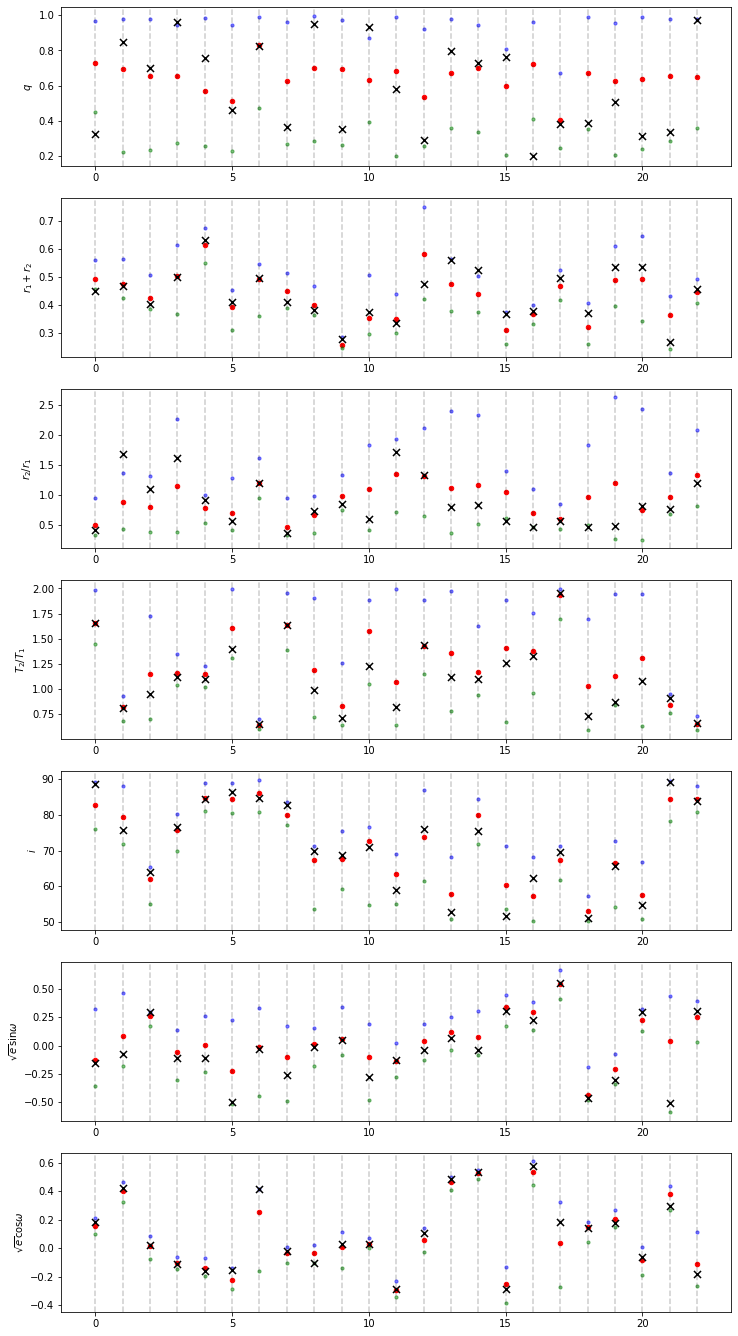

In [19]:
skip=3
length = len(db_params_interp[:,0][::skip])
fig, axes = plt.subplots(len(db_database_params_new[0]), figsize=(12,24))
for i in range(len(axes)):
    axes[i].scatter(range(length), db_params_interp[:,i][::skip], marker='o', c='r', s=20)
    axes[i].scatter(range(length), db_params_min[:,i][::skip], marker='o', c='g', s=10, alpha=0.5)
    axes[i].scatter(range(length), db_params_max[:,i][::skip], marker='o', c='b', s=10, alpha=0.5)
    axes[i].scatter(range(length), db_test_params_new[:,i][::skip], marker='x', c='k', s=50)
    for j in range(length):
        axes[i].axvline(x=j, c='k', linestyle='--', alpha=0.2)
    axes[i].set_ylabel(db_param_names_new[i])